In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import qgrid

### CCXT

In [2]:
polo = ccxt.poloniex({
    'apiKey': cfg.POLONIEX_API_KEY,
    'secret': cfg.POLONIEX_API_SECRET_KEY,
})
gdax = ccxt.gdax({
    'apiKey': cfg.GDAX_API_KEY,
    'secret': cfg.GDAX_API_SECRET_KEY,
    'password': cfg.GDAX_PASSPHRASE,
    'verbose':False,
})
binance = ccxt.binance()

exchange = binance
markets = exchange.load_markets()

#print(exchange.id, markets)
#print(exchange.fetch_order_book(exchange.symbols[0]))
#print(exchange.fetch_ticker('ETH/BTC')) # coin/market - base/quote
#print(exchange.fetch_trades('LTC/BTC'))

### Ingest Data

In [23]:
# Get historical data
coins = [c.BTC, c.ETH, c.LTC]#, c.ETH, c.XRP, c.XMR, c.DASH]
market = c.USDT
coin = c.LTC
symbol = ohlcv.get_symbol(coin, market)
period = '1m' #1800
#start = datetime.datetime(year=2018, month=1, day=4, hour=14)
start = datetime.datetime.utcnow() - datetime.timedelta(hours=2)
end = datetime.datetime.utcnow() - datetime.timedelta(hours=0)

In [24]:
# Single Coin
df = ohlcv.fetch_and_save_ohlcv_data(exchange, coin, market, period, start, end)
df.head()

Downloading: LTC/USDT
Downloaded rows: 120


,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515128280,237.05,237.05,235.54,235.54,3.76646,2018-01-05 04:58:00
1515128340,236.68,236.68,236.28,236.28,0.64080,2018-01-05 04:59:00
1515128400,236.28,236.69,235.94,236.28,2.33100,2018-01-05 05:00:00
1515128460,236.28,237.06,235.97,235.98,19.19505,2018-01-05 05:01:00
1515128520,237.03,237.03,236.99,236.99,19.70281,2018-01-05 05:02:00


In [25]:
# Multiple Coins
ohlcv.download_chart_data(exchange, coins, market, period, start, end)
df = ohlcv.load_multi_coin_data(exchange.id, coins, market, period, start)
df.head()

Downloading: BTC/USDT
Downloaded rows: 120
Downloading: ETH/USDT
Downloaded rows: 120
Downloading: LTC/USDT
Downloaded rows: 120


,BTC/USDT,ETH/USDT,LTC/USDT,time_utc
time_epoch,,,,
1515128280,14865.82,1009.95,235.54,2018-01-05 04:58:00
1515128340,14820.05,1008.83,236.28,2018-01-05 04:59:00
1515128400,14825.78,1006.63,236.28,2018-01-05 05:00:00
1515128460,14828.02,1008.07,235.98,2018-01-05 05:01:00
1515128520,14872.92,1006.64,236.99,2018-01-05 05:02:00


### Feeds

In [26]:
# CSV Feed
feed_fpath = ohlcv.get_price_data_fpath(coin=c.LTC, market=c.USDT, exchange_id=exchange.id, period='1m')
feed = CSVDataFeed(feed_fpath)
feed.initialize()

Loading feed: data/binance_LTC_USDT_1m.csv


In [27]:
# Grab 1 row at a time
for i in range(3):
    data = feed.next()
    print(data['time_utc'], data['close'])

2018-01-05 04:58:00 235.54
2018-01-05 04:59:00 236.28
2018-01-05 05:00:00 236.28


In [28]:
# Access all rows in history
feed.history.head()

,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515128340,236.68,236.68,236.28,236.28,0.64080,2018-01-05 04:59:00
1515128400,236.28,236.69,235.94,236.28,2.33100,2018-01-05 05:00:00
1515128460,236.28,237.06,235.97,235.98,19.19505,2018-01-05 05:01:00
1515128520,237.03,237.03,236.99,236.99,19.70281,2018-01-05 05:02:00
1515128580,236.99,237.00,235.98,237.00,66.42281,2018-01-05 05:03:00


In [88]:
# Exchange Live Feed

coins = [c.ETH, c.XRP, c.XMR]
market = c.BTC
period = '1m'
start = datetime.datetime.utcnow() - datetime.timedelta(hours=1)
end = None
feed_fpath = ohlcv.get_price_data_fpath(coins[2], market, exchange.id, period)

In [89]:
feed = ExchangeDataFeed(exchange, [coins[2]], market, period, feed_fpath, start, end)
feed.initialize()

Loading feed: data/binance_XMR_BTC_1m.csv
Downloading: XMR/BTC
Downloaded rows: 61


In [90]:
# Access History
feed.history.head()

,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515132960,0.024084,0.024213,0.024084,0.024099,22.987,2018-01-05 06:16:00
1515133020,0.024101,0.024195,0.024101,0.024195,2.209,2018-01-05 06:17:00
1515133080,0.024111,0.024194,0.024092,0.024093,53.653,2018-01-05 06:18:00
1515133140,0.024104,0.024114,0.024094,0.024114,9.100,2018-01-05 06:19:00
1515133200,0.024102,0.024188,0.024102,0.024105,6.602,2018-01-05 06:20:00


In [91]:
# Grab 1 row at a time (don't refresh data)
for i in range(3):
    data = feed.next(refresh=False)
    print(data['time_utc'], data['close'])

2018-01-05 06:16:00 0.024099
2018-01-05 06:17:00 0.024195
2018-01-05 06:18:00 0.024093


In [92]:
# Refresh data before next query
data = feed.next(refresh=True)
print(data['time_utc'], data['close'])

Downloading: XMR/BTC
Downloaded rows: 58
2018-01-05 06:19:00 0.024114


In [93]:
# Example Using the Feed

def my_strategy(row, history, exchange):
    print("Time:", row['time_utc'], "Price:", row['close'])
    if row['close'] > .024:
        print("Buying coin")
        #res = exchange.limit_buy(quantity=1, price=5)
    else:
        print("Selling that stupid coin")
    return {
        'time': row['time_utc'],
        'close': row['close'],
        'action': 'buy',
        'quantity': 1,
        'price': 5,
        'exchange': exchange.id
    }

def backtest(feed, strategy, exchange):
    results = []
    row = feed.next()
    while row is not None:
        output = strategy(row, feed, exchange)
        row = feed.next(refresh=True)
        results.append(output)
    return results

In [97]:
res = backtest(feed, my_strategy, exchange)

No data after prior poll: 2018-01-05 07:16:00


### Strategy

In [225]:
# https://www.backtrader.com/docu/quickstart/quickstart.html
# https://enigmampc.github.io/catalyst/beginner-tutorial.html#basics

class Strategy():
    def __init__(self, context):
        self.ctx = context
        self.initialize()
    
    def initialize(self):
        self.ctx.symbol = 'BTC/USD'
    
    def handle_data(self, data):
        # Handle next iteration of data from feed
        pass
    
class TestStrategy():
    def __init__(self):
        pass
    
    def next(self, data):
        pass

### Plotting

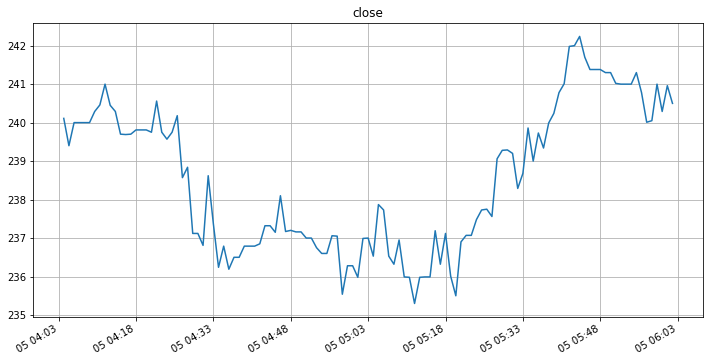

In [262]:
utils.charts.plot_range(feed.history, start, end, 'close')

### Exchange

In [118]:
# https://github.com/ccxt/ccxt/blob/master/python/ccxt/base/exchange.py

class Exchange():
    def __init__(self):
        pass

class CCXTExchange(Exchange):
    def __init__(self, exchange_client):
        self.ex = exchange_client
        
    def fetch_balance(self):
        return self.ex.fetch_balance()
    
    def limit_buy(self, symbol, quantity, price):
        return self.ex.create_limit_buy_order(symbol, quantity, price)
    

class TestExchange(Exchange):
    def __init__(self):
        self.orders = {'BTC/USD':[]}
        self.trades = {}
        self.fees = {'trading': .025, 'funding': .025}
        self.balance = {
            'BTC': {'free': 0.0, 'total': 0.0, 'used': 0.0},
            'USD': {'free': 0.6, 'total': 0.6, 'used': 0.0},
            'free': {'BCH': 0.0, 'BTC': 0.6, 'ETH': 0.0, 'LTC': 0.0, 'USD': 486.3}
        }
    
    def fetch_balance(self):
        return self.balance
    
    def limit_buy(self, coin, market, quantity, price):
        symbol = ohlcv.get_symbol(coin, market)
        self.orders[symbol].append("NEW_ORDER")
        
        # We assume the order goes through
        self.balance[market]['free'] -= quantity * price
        self.balance[coin]['used'] += quantity * price
        
        # Account for fees here
        self.balance[market]['total'] -= self.fees['trading']
        return self.orders

In [120]:
ex = TestExchange()
print(ex.fetch_balance())
orders = ex.limit_buy(c.BTC, c.USD, 1, 15000.0)
orders

{'BTC': {'free': 0.0, 'total': 0.0, 'used': 0.0}, 'USD': {'free': 0.6, 'total': 0.6, 'used': 0.0}, 'free': {'BCH': 0.0, 'BTC': 0.6, 'ETH': 0.0, 'LTC': 0.0, 'USD': 486.3}}


{'BTC/USD': ['NEW_ORDER']}

In [ ]:
EX = Exchange(gdax)

### Runner

In [ ]:
from enum import Enum, unique

@unique
class TradeMode(Enum):
    BACKTEST = 0
    SIMULATE = 1
    LIVE = 2

class Punisher():
    def __init__(self, exchange, feed, strategy, record):
        self.exchange = exchange
        self.feed = feed
        self.strategy = strategy
        self.record = {
            'test': [],
            'live': []
        }
        
    def backtest(self):
        results = []
        row = feed.next()
        while row is not None:
            print("Timestep", row['time_utc'], "Price", row['close'])
            row = feed.next()
            output = self.strategy(row, exchange, feed)
            results.append(output)
        return results
    
    def simulate(self):
        while True:
            row = feed.next()
            if row is not None:
                output = self.strategy(row, exchange, feed)
                self.record['test'].append(output)
            time.sleep(2)

    def live(self):
        while True:
            row = feed.next()
            if row is not None:
                output = self.strategy(row, exchange, feed)
                self.record['live'].append(output)
            time.sleep(2)
    
    def punish(self, mode=False):
        if mode == TradeMode.BACKTEST:
            print("Backtesting ...")
            self.backtest()
        elif mode == TradeMode.SIMULATE:
            print("Simulating orders ...")
            self.simulate()
        elif mode == TradeMode.LIVE:
            print("LIVE TRADING! CAREFUL!")
            self.live()

### Trading

In [ ]:
# Trading
print(exchange.fetch_balance())

# sell one ฿ for market price and receive $ right now
print(exchange.id, exchange.create_market_sell_order('BTC/USD', 1))

# limit buy BTC/EUR, you pay €2500 and receive ฿1  when the order is closed
print(exchange.id, exchange.create_limit_buy_order('BTC/EUR', 1, 2500.00))

# pass/redefine custom exchange-specific order params: type, amount, price, flags, etc...
polo.create_market_buy_order('BTC/USD', 1, {'trading_agreement': 'agree'})